<a href="https://colab.research.google.com/github/benchov/Machine_Learning_for_Trading_Knowledge/blob/main/PCA_and_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ta
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=8757f86a668d302b2aaa5abe88e083c48fad1a182701302a6adfc1b000f936e7
  Stored in directory: /root/.cache/pip/wheels/1b/81/50/db21d9643326c61dd6fee1dc2562d8351ee7753164c24ead38
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 5.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully unin

In [2]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from ta import add_all_ta_features
import yfinance as yf

# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

In [3]:
# Data Extraction|
start_date = '2017-01-01'
end_date = '2022-06-01'
symbol = "^VIX"
df = yf.download(symbol, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,0
2017-01-04,12.78,12.80,11.63,11.85,11.85,0
2017-01-05,11.96,12.09,11.40,11.67,11.67,0
2017-01-06,11.70,11.74,10.98,11.32,11.32,0
2017-01-09,11.71,12.08,11.46,11.56,11.56,0


In [4]:
# add TA features
df = add_all_ta_features(df, open="Open", high='High', low="Low", close='Adj Close', volume="Volume", fillna=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1362 entries, 2017-01-03 to 2022-05-31
Data columns (total 92 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Open                       1362 non-null   float64
 1   High                       1362 non-null   float64
 2   Low                        1362 non-null   float64
 3   Close                      1362 non-null   float64
 4   Adj Close                  1362 non-null   float64
 5   Volume                     1362 non-null   int64  
 6   volume_adi                 1362 non-null   float64
 7   volume_obv                 1362 non-null   int64  
 8   volume_cmf                 1362 non-null   float64
 9   volume_fi                  1362 non-null   float64
 10  volume_em                  1362 non-null   float64
 11  volume_sma_em              1362 non-null   float64
 12  volume_vpt                 1362 non-null   float64
 13  volume_vwap                136

In [5]:
# data preprocessing - stationarity
non_stationaries = []
for col in df.columns:
  dftest = adfuller(df[col].values)
  p_value = dftest[1]
  t_test = dftest[0] < dftest[4]['1%']
  if p_value > 0.05 or not t_test:
    non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 29


In [6]:
# convert non-stationary to stationary
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]
df_stationary.shape

(1361, 92)

In [7]:
# drop NA cols
na_list = df_stationary.columns[df_stationary.isna().any().to_list()]
df_stationary.drop(columns=na_list, inplace=True)
df_stationary.shape

(1361, 80)

In [8]:
# handle infinite values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Open,High,Low,Close,Adj Close,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,...,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,12.78,12.80,-0.094942,11.85,11.85,0.0,0.0,12.350000,0.038911,-0.116732,...,-90.983594,0.000000,0.0,-0.624394,-0.124879,-0.499515,-0.058492,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,-0.019776,11.67,11.67,0.0,0.0,12.123334,-0.014123,-0.023329,...,-89.887624,0.000000,0.0,-1.226732,-0.345249,-0.881483,-0.022532,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,-0.036842,11.32,11.32,0.0,0.0,11.922500,-0.007763,-0.027018,...,-88.996759,0.000000,0.0,-1.916831,-0.659566,-1.257265,-0.027227,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,0.043716,11.56,11.56,0.0,0.0,11.850000,-0.011637,0.000646,...,-81.229746,0.000000,0.0,-2.289756,-0.985604,-1.304152,0.002666,2.120148,2.097985,-10.038910
2017-01-10,11.59,11.79,-0.013089,11.49,11.49,0.0,0.0,11.790000,-0.008950,-0.000415,...,-83.495139,-0.288667,0.0,-2.607109,-1.309905,-1.297204,-0.002328,-0.605542,-0.607383,-10.583662


In [9]:
# set target
df_stationary["Target"] = -1
df_stationary.loc[df_stationary["Adj Close"].shift(-1) > df_stationary["Adj Close"], 'Target'] = 1
df_stationary.dropna(inplace=True)

In [10]:
# split target from feature set
X = df_stationary.iloc[:,:-1]
y = df_stationary.iloc[:, -1]

In [11]:
# feature scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [12]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=883)

In [13]:
# PCA - dimensionality reduction
n_components = 8
pca = PCA(n_components=n_components)
pca_result = pca.fit(X_train)
X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

In [14]:
# Calculate the variance explained by Principle Components
print("Variance of each component: ", pca.explained_variance_ratio_)
print("\n Total Variance Explained: ", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

Variance of each component:  [0.33921548 0.20621016 0.08753918 0.05074902 0.03989274 0.03323609
 0.02684418 0.02305871]

 Total Variance Explained:  80.67


In [15]:
pca_cols = []
for i in range(n_components):
  pca_cols.append(f"col_{i}")
pca_cols

['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7']

In [16]:
# create new dataframe
df_pca = pd.DataFrame(data=X_train_pca, columns=pca_cols)
df_pca.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0.077182,1.645838,1.773791,-0.858145,-0.364342,0.225055,-0.463436,-0.683355
1,-7.180006,5.882270,-6.050414,1.722763,0.870275,1.388710,1.953714,-1.777008
2,-4.498013,5.543755,1.155177,-2.575533,0.258185,-0.007386,-0.359458,-1.830726
3,-0.233168,1.492241,0.391339,-0.973712,0.209413,-1.134178,-0.079393,0.894924
4,-4.263053,6.580600,-0.466939,-0.640465,-0.251391,-0.185667,0.358136,-2.157346


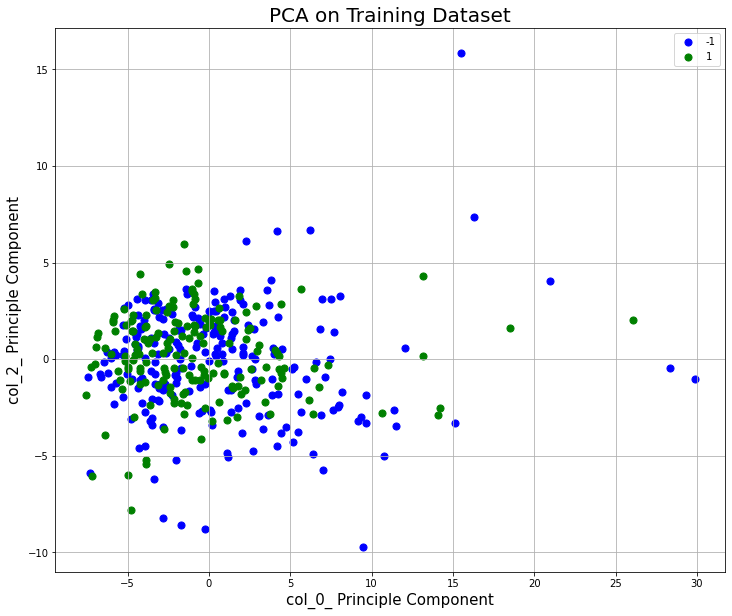

In [17]:
# Visualize Principle Components with Scatter Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1,1,1)
col_1 = "col_0"
col_2 = "col_2"
ax.set_xlabel(f"{col_1}_ Principle Component", fontsize=15)
ax.set_ylabel(f"{col_2}_ Principle Component", fontsize=15)
ax.set_title("PCA on Training Dataset", fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets, colors):
    indices_to_keep = y_train == target
    indices_to_keep = list(indices_to_keep)
    ax.scatter(df_pca.loc[indices_to_keep, col_1],
               df_pca.loc[indices_to_keep, col_2],
               c = color,
               s=50)
ax.legend(targets)
ax.grid()

In [22]:
# supervised ML - Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=883)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.577124868835257
Test Precision: 0.5375


In [23]:
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba

array([[0.56365712, 0.43634288],
       [0.66314125, 0.33685875],
       [0.68634931, 0.31365069],
       ...,
       [0.66610487, 0.33389513],
       [0.49531939, 0.50468061],
       [0.60633401, 0.39366599]])

In [24]:
train_scores, test_scores = list(), list()
values = [i for i in range(1,200)]
for i in values:
  model_1 = RandomForestClassifier(n_estimators=i, max_depth=4, random_state=883)
  model_1.fit(X_train, y_train)
  
  train_prediction = model_1.predict(X_train)
  train_accuracy = accuracy_score(y_train, train_prediction)
  train_scores.append(train_accuracy)

  test_prediction = model_1.predict(X_test)
  test_accuracy = accuracy_score(y_test, test_prediction)
  test_scores.append(test_accuracy)

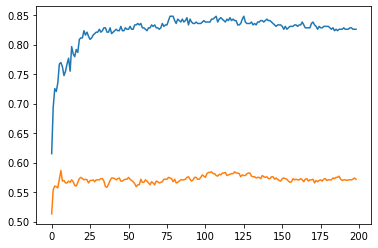

In [26]:
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()

In [ ]:
I 